# Load 2K to test effectiveness

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
debug_mode=1 # if not in debug mode, please set debug_mode=0, find more info about debug mode in test run 9 maybe?
%load_ext autoreload
%autoreload 2
%matplotlib inline

## I. Background
### A. Preprocessing the Corpus and Save to the Database (Done)

The corpus could be downloaded [here](https://github.com/xeniaqian94/snorkel/blob/master/abstractnet/testrun/data/slim-slim-top-tier-citation).

In [3]:
import os
os.environ['SNORKELDB'] = "postgresql:///abstractnet2k"
print(os.environ['SNORKELDB'])
from snorkel import SnorkelSession
from snorkel.parser import TSVDocPreprocessor
session = SnorkelSession()

## Here, we just set the upperbound for how many documents we'll process!
n_docs = 3000 
doc_preprocessor = TSVDocPreprocessor('data/annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv', encoding="utf-8",max_docs=n_docs)

from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, count=n_docs)# ,parallelism=5)

from snorkel.models import Document, Sentence  # defined in context.py file
print("Documents:", session.query(Document).count())

postgresql:///abstractnet2k
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
clear finished!
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 48.2 s, sys: 1.45 s, total: 49.7 s
Wall time: 1min 11s
Documents: 2050


### B. Connect to the Database and retrieve Document

Recall the Document/Sentence/Candidate hierarchy in the guideline. We also divide the whole document set into buckets of each 100 documents.

In [4]:
from snorkel import SnorkelSession
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence
from collections import defaultdict
import numpy as np

session = SnorkelSession()
docs = session.query(Document).all()
sents = session.query(Sentence).all()  # get all sentences from snorkel.db

docs_per_bucket=520
sents_split=defaultdict(lambda:[])
for ind, doc in enumerate(docs):
    bucket=int(ind/docs_per_bucket)
    for s in doc.sentences:
        sents_split[bucket]+=[s]
print("Number of buckets", len(sents_split))

Number of buckets 4


### C. From Documents to Extract Candidates

Here we extract the candidates (i.e. unigrams) from one of the document bucket, which has approximately 100 documents. Here we use <b>Bucket 0</b>. So it is our train bucket to learn the generative model from LFs. Later we will use <b>Bucket 1</b> as the development bucket, to draw visualizations and provide feedbacks. 

In [5]:
from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import *
import datetime

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Unigram = candidate_subclass('Unigram', ['unigram_cue'],values=['PP','MN','NULL'])
ngrams = Ngrams(n_max=1) 
ngram_matcher=NgramMatcher()
unigram_segment_extractor=CandidateExtractor(Unigram,[ngrams],[ngram_matcher])

train_bucket=0
%time unigram_segment_extractor.apply(sents_split[train_bucket], split=train_bucket)
unigram_segments=session.query(Unigram).filter(Unigram.split == train_bucket).all()
print("Number of Candidates/Unigrams",len(unigram_segments))

Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 2min 37s, sys: 10.9 s, total: 2min 48s
Wall time: 5min 48s
Number of Candidates/Unigrams 101769


### D. Data Exploration 

Let's visualize some Candidates/Unigrams with SentenceNgramViewer. 

In [6]:
from snorkel.viewer import SentenceNgramViewer

unigram_segments=session.query(Unigram).filter(Unigram.split == train_bucket).all()
SentenceNgramViewer(unigram_segments[0:100], session, n_per_page=10)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[0, 6, 12, 14, 17, 23, 25, 27, 33, 35, 39, 40, 44, 49, 51, 56], [1, 4, 9, 13, 18, 2…

## II. Labeling Functions
### A. Load the n-th version of LFs

In this n-th version, a majority of our LFs are cue-based LFs. You can tell from the names!

In [7]:
from snorkel.lf_helpers import *
from snorkel.annotations import LabelAnnotator

# from LF.util_common_default_categorical import purpose_LFs,mechanism_LFs,null_LFs
from LF.util_common_default_categorical_1024 import purpose_LFs,mechanism_LFs,null_LFs
print("total LF count", len(purpose_LFs+mechanism_LFs+null_LFs), "unique count",len(set(purpose_LFs+mechanism_LFs+null_LFs)),"purpose_LFs",len(purpose_LFs),"mechanism_LFs",len(mechanism_LFs))
print("\n\npurpose_LFs\n",[lf.__name__ for lf in purpose_LFs])
print("\n\nmechanism_LFs\n",[lf.__name__ for lf in mechanism_LFs])
print("\n\nnull_LFs\n",[lf.__name__ for lf in null_LFs])

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2050it [00:00, 23200.02it/s]

total LF count 202 unique count 202 purpose_LFs 74 mechanism_LFs 58


purpose_LFs
 ['LF_purpose_the_problem_of3_True', 'LF_purpose_the_problem_ofneg2_True', 'LF_purpose_the_task_of3_True', 'LF_purpose_the_task_ofneg2_True', 'LF_purpose_challenge3_True', 'LF_purpose_challengeneg2_True', 'LF_purpose_to_understand3_True', 'LF_purpose_to_understandneg2_True', 'LF_purpose_to_answer3_True', 'LF_purpose_to_answerneg2_True', 'LF_purpose_issue3_True', 'LF_purpose_issueneg2_True', 'LF_purpose_useful_to3_True', 'LF_purpose_useful_toneg2_True', 'LF_purpose_investigate3_True', 'LF_purpose_investigateneg2_True', 'LF_purpose_we_study3_True', 'LF_purpose_we_studyneg2_True', 'LF_purpose_we_explore3_True', 'LF_purpose_we_exploreneg2_True', 'LF_purpose_although3_True', 'LF_purpose_althoughneg2_True', 'LF_purpose_know_little_3_True', 'LF_purpose_know_little_neg2_True', 'LF_purpose_deals_with_3_True', 'LF_purpose_deals_with_neg2_True', 'LF_purpose_we_explore3_True', 'LF_purpose_we_exploreneg2_True', 'LF_pu

## VI. Development Sandbox
### A. Writing New Labeling Functions

We will name them as `new_LFs`.

In [8]:
#
# PLACE YOUR LFs HERE
#
new_LFs=[]

### B. Applying Labeling Functions

In here we define two functions: (1) applying LFs to get an annotation matrix; (2) use the annotation matrix to learn a generative model.

In [9]:
from snorkel.learning import GenerativeModel
from util import get_candidate_text
import matplotlib.pyplot as plt
import datetime

def get_L_train(LFs,parallelism=1,split=0):
    L_train=None
    labeler=None
    np.random.seed(1701)
    labeler = LabelAnnotator(lfs=LFs)
    print(datetime.datetime.now())
    L_train = labeler.apply(split=split,parallelism=parallelism)# ,cids_query=session.query(Candidate.id).filter(Candidate.get_parent().id %10==1))
    print(datetime.datetime.now())
    print(type(L_train))
    print(L_train.shape)
    printmd("**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  "+str(L_train.non_overlapping_coverage()))
    return L_train

def get_train_marginals(L_train,step_size_nominator=0.1,epochs=100,lf_propensity=True,threads=1,class_prior=False,decay=1.0,reg_param=1e-6):
    try:
        gen_model=None
        print(datetime.datetime.now())
        gen_model = GenerativeModel(lf_propensity=lf_propensity,class_prior=class_prior)
        gen_model.train(L_train, cardinality=3, epochs=epochs, decay=decay,step_size=step_size_nominator/1e2,reg_param=reg_param,verbose=False,threads=threads)
        print("training finished ")
        print(datetime.datetime.now())
        print("Finished training generative model, now checking performance against development set labels...")
        print("Calculating marginals!")
        train_marginals = gen_model.marginals(L_train)  # the marginal probability of each candidate being True
        print("no exception")
        print(datetime.datetime.now())
        return gen_model,train_marginals
    except:
        print("exception! ")
        return gen_model,train_marginals


In [13]:
L_train=get_L_train(purpose_LFs+mechanism_LFs+null_LFs+new_LFs)
print(L_train.shape)

2050it [00:00, 10774.45it/s]


snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-24 21:35:58.837307
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 101769
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-24 21:56:16.263107
<class 'snorkel.annotations.csr_LabelMatrix'>
(101769, 187)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6408533050339494

(101769, 187)


In [14]:
import pandas as pd 
pd.set_option('display.max_rows', 500)

df=L_train.lf_stats(session)
df['Conflict_Coverage_ratio'] = df['Conflicts']/df['Coverage']

df_ratio_added=df.sort_values(by=['Conflict_Coverage_ratio'],ascending=False)

# df_ratio_added[df_ratio_added.index.str.contains("we_similar")]
df_ratio_added


,j,Coverage,Overlaps,Conflicts,Conflict_Coverage_ratio
LF_mechanism_are_proposed3_True,95,0.000039,0.000039,0.000039,1.000000
LF_mechanism_are_proposedneg1_True,96,0.000334,0.000334,0.000334,1.000000
LF_null_finds_that3_True,131,0.000020,0.000020,0.000020,1.000000
LF_null_finds_thatneg2_True,132,0.000246,0.000246,0.000246,1.000000
LF_purpose_our_goal_isneg2_True,35,0.001503,0.001494,0.001327,0.882353
LF_purpose_our_goal_is3_True,34,0.000069,0.000059,0.000059,0.857143
LF_purpose_ways_toneg2_True,33,0.000845,0.000845,0.000678,0.802326
LF_purpose_that_allows3_True,30,0.000413,0.000364,0.000314,0.761905
LF_null_lemma_interviewneg2_True,180,0.000118,0.000098,0.000088,0.750000
LF_purpose_the_task_of3_True,2,0.000039,0.000039,0.000029,0.750000


In [13]:
for reg_param in [1e-3]:#,1e-6]: #[1e-3, 1e-6]:
    for decay in [0.95]: #[1.0,0.95]:
        for step_size_nominator in [0.01,0.001]: # [0.01, 0.1, 1]:
            for epochs in [2,3,4,5,7]:#,30,50,100,200,500]:
                for lf_propensity in [False]:
                    
                    print("grid search with L_train","step_size_nominator",step_size_nominator,"epochs",epochs,"decay",decay,"reg_param",reg_param,"lf_propensity",lf_propensity)
                    gen_model,train_marginals=get_train_marginals(L_train,threads=18,lf_propensity=lf_propensity,step_size_nominator=step_size_nominator,epochs=epochs,decay=decay,reg_param=reg_param)
                    assert np.all(train_marginals.sum(axis=1) - np.ones(train_marginals.shape[0]) < 1e-10)

                    winHighlight=train_marginals.argmax(axis=1)
                    print("PP",(winHighlight==0).sum())
                    print("MN",(winHighlight==1).sum())
                    print("NULL",(winHighlight==2).sum())

                    # Amendment!!! winning highligh with default as NULL (the last occurence of largest value)
                    train_marginals_reverse = train_marginals[:,::-1]
                    winHighlight = train_marginals.shape[1] - np.argmax(train_marginals_reverse,axis=1) - 1
                    print("amend PP",(winHighlight==0).sum())
                    print("amend MN",(winHighlight==1).sum())
                    print("amend NULL",(winHighlight==2).sum())


grid search with L_train step_size_nominator 0.01 epochs 2 decay 0.95 reg_param 0.001 lf_propensity False
2018-10-24 12:08:07.465658
Compiles variable matrix
exception! 


UnboundLocalError: local variable 'train_marginals' referenced before assignment

### C. Learning the Generative Model

In [15]:
reg_param=1e-3
decay=0.95
step_size_nominator=0.01
epochs=5
lf_propensity=False
                        
print("train starts here", datetime.datetime.now())
gen_model,train_marginals=get_train_marginals(L_train,threads=18,step_size_nominator=step_size_nominator,lf_propensity=lf_propensity,epochs=epochs,decay=decay,reg_param=reg_param)
assert np.all(train_marginals.sum(axis=1) - np.ones(train_marginals.shape[0]) < 1e-10)

winHighlight=train_marginals.argmax(axis=1)
print("PP",(winHighlight==0).sum())
print("MN",(winHighlight==1).sum())
print("NULL",(winHighlight==2).sum())

# Amendment!!! winning highligh with default as NULL (the last occurence of largest value)
train_marginals_reverse = train_marginals[:,::-1]
winHighlight = train_marginals.shape[1] - np.argmax(train_marginals_reverse,axis=1) - 1
print("amend PP",(winHighlight==0).sum())
print("amend MN",(winHighlight==1).sum())
print("amend NULL",(winHighlight==2).sum())

train starts here 2018-10-24 22:00:52.117615
2018-10-24 22:00:52.117872
Compiles variable matrix
_compile finished!
Compiles variable matrix
_compile finished!
training finished 
2018-10-24 22:13:51.208813
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
no exception
2018-10-24 22:14:14.791124
PP 58517
MN 26163
NULL 17089
amend PP 21967
amend MN 26163
amend NULL 53639


### D. Visualize generative labels on this train set, then on the dev set

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
dispatch finished!! 


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
dispatch finished!! 
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
dispatch finished!! 
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
dispatch finished!! 
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
dispatch finished!! 
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
dispatch finished!! 


<Figure size 432x288 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

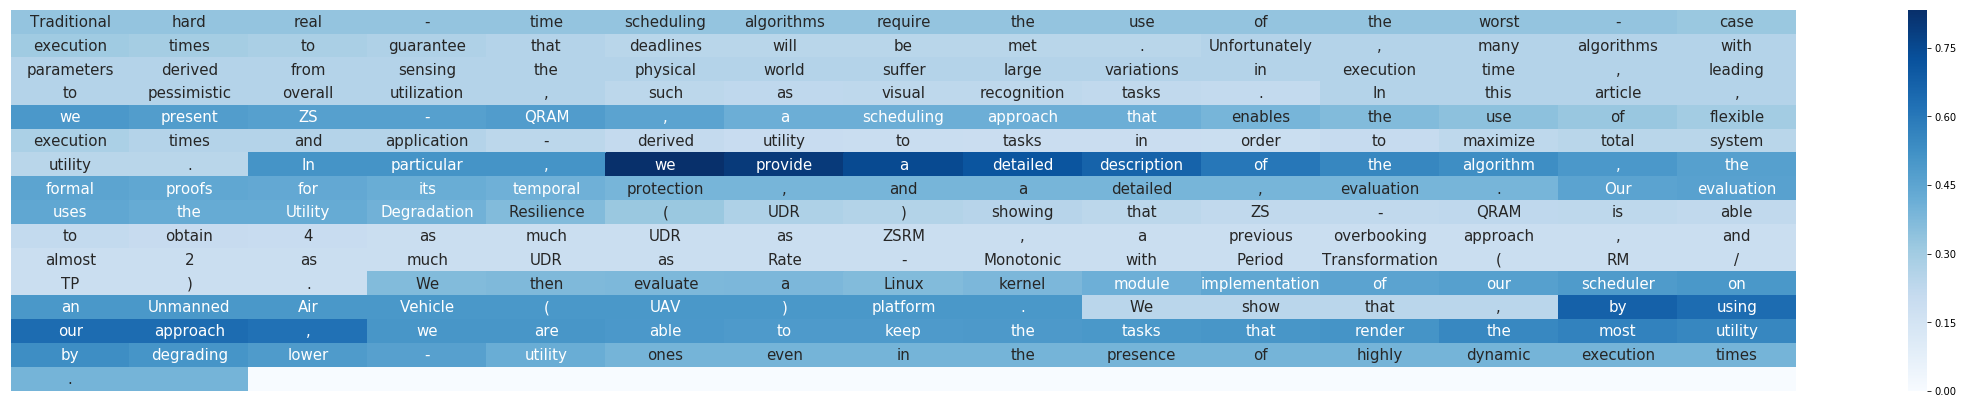

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pandas as pd

def pad_reshape(A,width,isFloat=False):
    B=np.empty([1,int(A.shape[1]/width+1)*width],dtype=object)
    if isFloat:
        B=np.zeros([1,int(A.shape[1]/width+1)*width])
        B[:,:A.shape[1]]=A
    else:
        B[:,:A.shape[1]]=A
        B[:,A.shape[1]:]=""
    return B.reshape(-1,width)
 

def create_new_score_array(smooth_window,score_array,word_array):
    new_score_array=np.zeros(score_array.shape)
    half_window=int(smooth_window/2)
    punctuation=[",","."]
    for i in range(score_array.shape[1]):
        sub_score_array=score_array[0,max(0,i-half_window):i+half_window+1]
        sub_word_array=word_array[0,max(0,i-half_window):i+half_window+1]

        mid_pos=half_window

        left_pos=mid_pos
        right_pos=mid_pos
#         print(sub_word_array[left_pos],type(sub_word_array[left_pos]))
        while left_pos>0 and str(sub_word_array[left_pos-1][0]) not in punctuation:
            left_pos-=1
        while right_pos<len(sub_word_array):
            right_pos+=1
            if str(sub_word_array[right_pos-1][0]) in punctuation:
                break
        new_score_array[0,i]=np.mean(sub_score_array[left_pos:right_pos])
    return new_score_array


    
def visualize_word_level(tag,unigram_segments,score_list,directory="data/word_level_tag_visualization",smooth_window=0,cmap="Greens"):
    doc_dict=defaultdict(lambda:[])

    pair_list=list(zip(unigram_segments,score_list))

    for ind,pair in enumerate(pair_list):
        if ind%10000==0:
            print(ind)
        docid=pair[0].get_parent().get_parent().name
        doc_dict[docid]+=[pair]
    print("dispatch finished!! ")

    for docid in doc_dict:
        plt.clf()
        doc_dict[docid]=sorted(doc_dict[docid], key=lambda pair: (pair[0].get_parent().position, pair[0].get_contexts()[0].get_word_start()))
        ordered_word_score_list=[(pair[0].get_parent().text[pair[0].unigram_cue.char_start:pair[0].unigram_cue.char_end+1], pair[1]) for pair in doc_dict[docid]]
        df=pd.DataFrame.from_records(ordered_word_score_list,columns=['word','score'])
        fig, ax = plt.subplots(figsize=(40,7))  
        width=15
        score_array=np.asarray(df[['score']]).reshape(1,-1)
        word_array=np.asarray(df[['word']]).reshape(1,-1)
        
        if smooth_window!=0:
            score_array=create_new_score_array(smooth_window,score_array,word_array)
#             print(new_score_array.shape)
        sns.heatmap(pad_reshape(score_array,width,isFloat=True), cmap=cmap, annot=pad_reshape(word_array,width),fmt='',yticklabels=False,xticklabels=False,ax=ax,annot_kws={"size": 15})
        plt.savefig(os.path.join(directory,"run",docid+"_"+tag))
  
sample_size=train_marginals.shape[0]
# visualize_word_level("PP",unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1))) 
# visualize_word_level("MN",unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)))

smooth_window=3
visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/2k") 
visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/2k")

smooth_window=5
visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/2k") 
visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/2k")

smooth_window=7
visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/2k") 
visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/2k")



We could now view visualization on this train set back in the directory.

In [31]:
# blind_bucket=1
# %time unigram_segment_extractor.apply(sents_split[blind_bucket], split=blind_bucket)
# unigram_segments_tmp=session.query(Unigram).filter(Unigram.split == blind_bucket).all()

# L_train_tmp=get_L_train(purpose_LFs+mechanism_LFs+null_LFs+new_LFs,split=blind_bucket)
# print("creating blind_marginals")

# train_marginals_tmp = gen_model.marginals(L_train_tmp)
# print("visualizing blind_marginals")
# sample_size=train_marginals_tmp.shape[0]
# smooth_window=3
# visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments_tmp[:sample_size],list(train_marginals_tmp[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/2k/blind") 
# visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments_tmp[:sample_size],list(train_marginals_tmp[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/2k/blind") 

We could now view visualization on this blind set back in the directory. Look for important mismatch between the visualized segmentation and any missed LFs.

In [17]:
def get_candidate_text(segment):
    return segment.get_parent().text[segment.unigram_cue.char_start:segment.unigram_cue.char_end+1]

def write_csv_gen_label(unigram_segments,train_marginals,csv_path,smooth_window=3):
    
    pair_list=list(zip(unigram_segments,train_marginals))
    new_unigram_segments=[]
    new_train_marginals=[]
    doc_dict=defaultdict(lambda:[])
    for ind,pair in enumerate(pair_list):
        if ind%10000==0:
            print(ind)
        docid=pair[0].get_parent().get_parent().name
        doc_dict[docid]+=[pair]

    for docid in doc_dict:
        doc_dict[docid]=sorted(doc_dict[docid], key=lambda pair: (pair[0].get_parent().position, pair[0].get_contexts()[0].get_word_start()))

        ordered_word_score_list=[(pair[0].get_parent().text[pair[0].unigram_cue.char_start:pair[0].unigram_cue.char_end+1], pair[1]) for pair in doc_dict[docid]]
        df=pd.DataFrame.from_records(ordered_word_score_list,columns=['word','score'])
        score_array=np.asarray(df[['score']]).reshape(1,-1)
        new_train_marginals_array=np.zeros([len(doc_dict[docid]),len(score_array[0,0])])
        word_array=np.asarray(df[['word']]).reshape(1,-1)
        for i in range(len(score_array[0,0])):
            
            segment_score_array=np.asarray([score_array[0,segment_idx][i] for segment_idx in range(len(doc_dict[docid]))]).reshape(1,-1)
            
            if smooth_window!=0:
                segment_score_array=create_new_score_array(smooth_window,segment_score_array,word_array)

            new_train_marginals_array[:,i]=segment_score_array
            

        for ind, pair in enumerate(doc_dict[docid]):
            new_unigram_segments+=[pair[0]]
            new_train_marginals+=[new_train_marginals_array[ind]]
      
    unigram_segments=new_unigram_segments
    train_marginals=new_train_marginals
        
    aggregated_doc=defaultdict(lambda:[])
    aggregated_sent=defaultdict(lambda:[])
    for idx,train_segment in enumerate(unigram_segments):
        sent_id=train_segment.get_parent().id    
        winningHighlight=list(train_marginals[idx])
        cue=train_segment.get_contexts()[0]
        aggregated_sent[sent_id]+=[(cue.char_start,cue.char_end,get_candidate_text(train_segment),winningHighlight)]

        doc_id=train_segment.get_parent().get_parent().name
        if doc_id not in aggregated_doc:
            aggregated_doc[doc_id]=train_segment.get_parent().get_parent().sentences


    df_list=[]      
    for doc_id in aggregated_doc:
        globalPsn=1
        for sent in aggregated_doc[doc_id]:
            sent_id=sent.id
            if sent_id not in aggregated_sent:
                raise ValueError('we have no info about this sent'+str(sent))
            aggregated_sent[sent_id]=sorted(aggregated_sent[sent_id], key=lambda x: x[0])
            for idx,pair in enumerate(aggregated_sent[sent_id]):
                text=pair[2]
                df_list+=[[pair[3],doc_id,globalPsn,text]]
                globalPsn+=1


    df=pd.DataFrame(df_list,columns=['winningHighlight', 'paperID', 'globalPsn','content'])
    df.to_csv(open(csv_path,"w"))   # in the spreadsheet, punctuations are splitted


for smooth_window in [3,5,7]:
    write_csv_gen_label(unigram_segments,train_marginals,"data/annotations_2k/split"+str(train_bucket)+"_window"+str(smooth_window)+".csv",smooth_window=smooth_window)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [18]:
# regroup annotation back to csv, also export smoothed score array 

for train_bucket in range(1,len(sents_split)):
    print("running train_bucket", train_bucket)
    if train_bucket!=0:
        %time unigram_segment_extractor.apply(sents_split[train_bucket], split=train_bucket)
    unigram_segments_tmp=session.query(Unigram).filter(Unigram.split == train_bucket).all()
    print("len(train_segments)",len(unigram_segments_tmp))
    print("applying L_train_tmp")
    L_train_tmp=get_L_train(purpose_LFs+mechanism_LFs+null_LFs,split=train_bucket)
    print("creating train_marginals")
    train_marginals_tmp = gen_model.marginals(L_train_tmp)
    
    for smooth_window in [3,5,7]:
        write_csv_gen_label(unigram_segments_tmp,train_marginals_tmp,"data/annotations_2k/split"+str(train_bucket)+"_window"+str(smooth_window)+".csv",smooth_window=smooth_window)
    
#     write_csv_gen_label(unigram_segments_tmp,train_marginals_tmp,"data/annotations_2k/split"+str(train_bucket)+".csv")


running train_bucket 1
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 2min 34s, sys: 9.57 s, total: 2min 43s
Wall time: 5min 10s
len(train_segments) 104491
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-24 23:00:01.817519
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 104491
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-24 23:17:26.506520
<class 'snorkel.annotations.csr_LabelMatrix'>
(104491, 187)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6096027409059154

creating train_marginals
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
running train_bucket 2
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 2min 31s, sys: 9.98 s, total: 2min 41s
Wall time: 5min 34s
len(train_segments) 101758
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-24 23:26:09.497621
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 101758
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? T

**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6016234595805735

creating train_marginals
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
running train_bucket 3
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 2min 54s, sys: 12.8 s, total: 3min 7s
Wall time: 6min 12s
len(train_segments) 94118
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-24 23:54:10.919323
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 94118
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True

**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6243332837501859

creating train_marginals
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
dispatch finished!! 


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
dispatch finished!! 


<Figure size 432x288 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

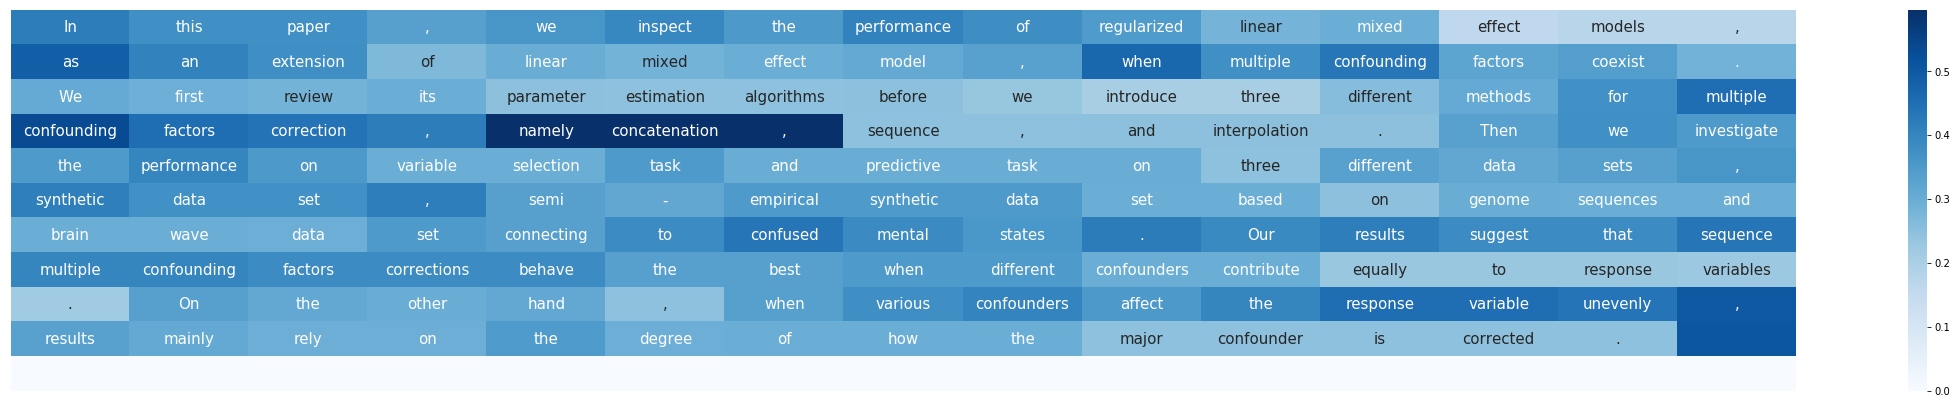

In [19]:
smooth_window=5
visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments_tmp,list(train_marginals_tmp.reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/2k") 
visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments_tmp,list(train_marginals_tmp.reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/2k")



In [61]:
# You're trying to build one large dataframe out of the rows of many dataframes who all have the same column names. axis should be 0 (the default), not 1. Also you don't need to specify a type of join. This will have no effect since the column names are the same for each dataframe.

# df = pd.concat([df1, df2, df3])

sub_dfs=[]
for train_bucket in range(len(sents_split)):
    sub_dfs+=[pd.read_csv(open("data/annotations_2k/split"+str(train_bucket)+".csv","r"))]
df = pd.concat(sub_dfs)
df=df.drop(columns=['Unnamed: 0'])
df.to_csv(open("data/annotations_2k/joint_split.csv","w"))

In [62]:
df2=df.copy()
import ast
import numpy as np

def transform_gm_label(x):
    x=ast.literal_eval(x)
    if abs(x[0]-x[1])<1e-4 and abs(x[1]-x[2])<1e-4:
        return [0,0,1]
    elif np.argmax(x)==0:
        return [1,0,0]
    return [0,1,0]

df2['winningHighlight'] = df2['winningHighlight'].apply(lambda x: transform_gm_label(x))
df2.to_csv(open("data/annotations_2k/joint_split_hard_as_soft.csv","w"))

In [65]:
import ast
import numpy as np

def transform_gm_label(x,threshold=0.33):
    x=ast.literal_eval(x)
    if abs(x[0]-x[1])<1e-4 and abs(x[1]-x[2])<1e-4:
        return [0,0,0]
    elif np.argmax(x)==0 and x[0]>threshold:
        return [1,0,0]
    elif np.argmax(x)==1 and x[1]>threshold:
        return [0,1,0]
    elif np.argmax(x)==2 and x[2]>threshold:
        return [0,0,1]
    else:
        return [0,0,0]

for threshold in [0.33, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    df2=df.copy()   
    df2['winningHighlight'] = df2['winningHighlight'].apply(lambda x: transform_gm_label(x,threshold=threshold))
    df2.to_csv(open("data/annotations_2k/joint_split_hard_as_soft_break_tie_"+str(threshold)+".csv","w"))
    

### Peripheral codes to examine Candidates

In [12]:
# TODO get_surrounding_words maybe group segments back to doc level from  Sentence has words in its __dict__ 

# visualize purpose probability


# pair_list=list(zip(unigram_segments,list(train_marginals[:,0].reshape(-1))))


# Find a test case span!!!
unigram_segments_tmp=session.query(Unigram).filter(Unigram.split == 0).all()

print(unigram_segments_tmp[0].get_parent().get_parent().sentences)

count=0
for idx,segment in enumerate(unigram_segments_tmp):
    if "but" in segment.get_parent().__dict__['words']:
#     if mechanism_LFs[-1](segment):
        print(idx,segment.get_parent().__dict__['text'])
        print(idx,segment.get_parent().get_parent().__dict__)
        if count>200:
            break
        count+=1
    
# input()
purpose_LFs=[]
from LF.util_common_default_categorical_1024 import purpose_LFs,mechanism_LFs

for i in range(1327,1329):
    print(unigram_segments_tmp[i])
    print(unigram_segments_tmp[i].get_parent().__dict__['text'])
    print(purpose_LFs[-1](unigram_segments_tmp[i]))
#     print(purpose_LFs[-1].__name__)
    print()
    
    
# print(unigram_segments[165],)

segment=unigram_segments[165]
# print((segment.get_contexts()[0].__dict__))
docid=segment.get_parent().get_parent().name
print(segment)
print("sent __dict__",segment.get_parent().__dict__)
print("sent pos in doc??", segment.get_parent().position)
# print("sent pos in doc??", segment.get_parent().get_parent().sentences.index(segment.get_parent()))

print(docid)

# print(segment.get_parent().get_parent().__dict__)
print(segment.get_parent().text[segment.unigram_cue.char_start:segment.unigram_cue.char_end+1])

unigram_psn=segment.unigram_cue.get_word_start()
print("unigram position?? ",unigram_psn)#.__dict__['words'])

its_pos_tag=segment.get_parent().__dict__['pos_tags'][unigram_psn]
print("its_pos_tag",its_pos_tag,"\n")

# its_surrounding_pos_tag=get_sourrounding_pos_tag(segment,3)
# print("unigram pos tag",get_sourrounding_pos_tag(segment,1))
# print("trigram pos tag",get_sourrounding_pos_tag(segment,3))
# print("5gram pos tag",get_sourrounding_pos_tag(segment,5))


[Sentence(Document 2K_dev_0,0,b'Online communities have the potential to be supportive, cruel, or anywhere in between.'), Sentence(Document 2K_dev_0,1,b'The development of positive norms for interaction can help users build bonds, grow, and learn.'), Sentence(Document 2K_dev_0,2,b'Using millions of messages sent in Twitch chatrooms, we explore the effectiveness of methods for encouraging and discouraging specific behaviors, including taking advantage of imitation effects through setting positive examples and using moderation tools to discourage antisocial behaviors.'), Sentence(Document 2K_dev_0,3,b'Consistent with aspects of imitation theory and deterrence theory, users imitated examples of behavior that they saw, and more so for behaviors from high status users.'), Sentence(Document 2K_dev_0,4,b'Proactive moderation tools, such as chat modes which restricted the ability to post certain content, proved effective at discouraging spam behaviors, while reactive bans were able to discoura

484 Social influence is key in technology adoption, but its role in security-feature adoption is unique and remains unclear.
484 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x15f1f27b8>, 'type': 'document', 'name': '2K_dev_11', 'stable_id': '2K_dev_11::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 12}
485 Social influence is key in technology adoption, but its role in security-feature adoption is unique and remains unclear.
485 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x15f1f27b8>, 'type': 'document', 'name': '2K_dev_11', 'stable_id': '2K_dev_11::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 12}
486 Social influence is key in technology adoption, but its role in security-feature adoption is unique and remains unclear.
486 {'_sa_instance_state': <sqlal

672 One approach would for experts to provide personalized feed-back, but this scales poorly, and may lead to premature convergence during creative work.
672 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x15f1f28d0>, 'type': 'document', 'name': '2K_dev_15', 'stable_id': '2K_dev_15::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 16}
673 One approach would for experts to provide personalized feed-back, but this scales poorly, and may lead to premature convergence during creative work.
673 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x15f1f28d0>, 'type': 'document', 'name': '2K_dev_15', 'stable_id': '2K_dev_15::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 16}
674 One approach would for experts to provide personalized feed-back, but this scales poorly, and ma

758 The results suggest that technological mediation influences decision making, but its influence depends on an individual 's self-construal: participants who saw themselves as defined through their relationships ( interdependent self-construal ) recommended riskier and more painful treatments in video conferencing than when face-to-face.
758 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x15f1f2400>, 'type': 'document', 'name': '2K_dev_17', 'stable_id': '2K_dev_17::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 18}
759 The results suggest that technological mediation influences decision making, but its influence depends on an individual 's self-construal: participants who saw themselves as defined through their relationships ( interdependent self-construal ) recommended riskier and more painful treatments in video conferencing than when face-to-face.
759 {'_sa_instance_s

1125 Prior research suggests that seeing particularly creative or diverse ideas from others can inspire you, but few scalable mechanisms exist to assess diversity.
1125 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x15e972358>, 'type': 'document', 'name': '2K_dev_26', 'stable_id': '2K_dev_26::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 27}
1126 Prior research suggests that seeing particularly creative or diverse ideas from others can inspire you, but few scalable mechanisms exist to assess diversity.
1126 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x15e972358>, 'type': 'document', 'name': '2K_dev_26', 'stable_id': '2K_dev_26::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 27}
1127 Prior research suggests that seeing particularly creative or diverse idea

1788 Crowd feedback systems offer designers an emerging approach for improving their designs, but there is little empirical evidence of the benefit of these systems.
1788 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1550f8cf8>, 'type': 'document', 'name': '2K_dev_42', 'stable_id': '2K_dev_42::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 43}
1789 Crowd feedback systems offer designers an emerging approach for improving their designs, but there is little empirical evidence of the benefit of these systems.
1789 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1550f8cf8>, 'type': 'document', 'name': '2K_dev_42', 'stable_id': '2K_dev_42::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 43}
1790 Crowd feedback systems offer designers an emerging approach for impro

2309 We suggest that these techniques might eliminate most of the effort of building unit generator libraries and could help with the implementation of embedded audio systems where unit generators are needed but a full embedded Csound engine is not required.

2309 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1550f8f98>, 'type': 'document', 'name': '2K_dev_54', 'stable_id': '2K_dev_54::document:0:0', 'meta': {'file_name': 'annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv'}, 'id': 55}
2310 We suggest that these techniques might eliminate most of the effort of building unit generator libraries and could help with the implementation of embedded audio systems where unit generators are needed but a full embedded Csound engine is not required.

2310 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1550f8f98>, 'type': 'document', 'name': '2K_dev_54', 'stable_id': '2K_dev_54::document:0:0', 'meta': {'file

### Related stackoverflow questions
https://datascience.stackexchange.com/questions/20071/how-do-i-load-fasttext-pretrained-model-with-gensim?noredirect=1


To test the effectivenss of fasttext WE:
1. we will examine the similarity between developed and develop
2. propose and proposed
3. introduce and propose
4. approach and method
5. approach and model
6. algorithm and model
7. algorithm and theory
5. datasets and benchmark 
6. dataset and corpus
7. explosive and emerging
8. emerging and arising
9. growth and development

In [ ]:
import gensim
import os
from gensim.models.word2vec import LineSentence
from gensim.models.fasttext import FastText as FT_gensim

model_wrapper.save('saved_model_wrapper')
loaded_model = FT_wrapper.load('saved_model_wrapper')
print(loaded_model)

print('night' in model_wrapper.wv.vocab)
print('nights' in model_wrapper.wv.vocab)
print(model_wrapper['night'])
print(model_wrapper['nights'])


from gensim.models.wrappers import FastText

model = FastText.load_fasttext_format('wiki.simple')

print(model.most_similar('teacher'))
# Output = [('headteacher', 0.8075869083404541), ('schoolteacher', 0.7955552339553833), ('teachers', 0.733420729637146), ('teaches', 0.6839243173599243), ('meacher', 0.6825737357139587), ('teach', 0.6285147070884705), ('taught', 0.6244685649871826), ('teaching', 0.6199781894683838), ('schoolmaster', 0.6037642955780029), ('lessons', 0.5812176465988159)]

print(model.similarity('teacher', 'teaches'))
# Output = 0.683924396754


